### Name: Ishika Gopie
### Student ID: 816018253
### COMP6940 A2 Section 2

# 1. Comparative Data Processing

# (a) Perform data loading and preprocessing tasks first using pandas (CPU) and then replicate the same tasks using cuDF (GPU). Document the time taken for each operation in both scenarios.

In [2]:
#!pip install pandas==1.5.3
#!pip install matplotlib

In [5]:
# !pip install \
#     --extra-index-url=https://pypi.nvidia.com \
#     cudf-cu12==24.2.* dask-cudf-cu12==24.2.* cuml-cu12==24.2.* \
#     cugraph-cu12==24.2.* cuspatial-cu12==24.2.* cuproj-cu12==24.2.* \
#     cuxfilter-cu12==24.2.* cucim-cu12==24.2.* pylibraft-cu12==24.2.* \
#     raft-dask-cu12==24.2.*

In [57]:
# Importing necessary libraries
import pandas as pd
import cudf
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

## Loading the Datasts

In [58]:
# create a dataframe to hold CPU Metrics
cpu_metrics = pd.DataFrame(columns=['Task', 'start_time', 'end_time', 'time_taken'])

# create a dataframe to hold GPU Metrics
gpu_metrics = pd.DataFrame(columns=['Task', 'start_time', 'end_time', 'time_taken'])

In [59]:
# Load the data using cuDF
start_time_gpu = time.time()
sample_submission_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/sample_submission.csv')
test_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/test.csv')
train_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/train.csv')
end_time_gpu = time.time()

In [60]:
# Load the data using pandas
start_time_cpu = time.time()
sample_submission_cpu = pd.read_csv('/kaggle/input/taxi-datasets/sample_submission.csv')
test_cpu = pd.read_csv('/kaggle/input/taxi-datasets/test.csv')
train_cpu = pd.read_csv('/kaggle/input/taxi-datasets/train.csv')
end_time_cpu = time.time()

In [61]:
# Display the time taken for data loading using pandas
print("Time taken for data loading using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for data loading using cuDF
print("Time taken for data loading using GUP: ", end_time_gpu - start_time_gpu)

Time taken for data loading using pandas:  5.760359048843384
Time taken for data loading using GUP:  0.2566866874694824


The time taken to load the data using GPU is 0.268 seconds and time taken to load the data using CPU is 5.638 seconds. The data loading process is faster using GPU compared to CPU.

In [62]:
# Add the metrics to the dataframe
cpu_metrics.loc[0] = ['Data Loading', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[0] = ['Data Loading', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

In [63]:
sample_submission_cpu.head(5)

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [64]:
test_cpu.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [65]:
train_cpu.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Data Preprocessing


In [66]:
# Data Preprocessing using cuDF
time_start_gpu = time.time()
# drop rows with missing values
train_gpu.dropna(inplace=True)
test_gpu.dropna(inplace=True)

# drop records with duplicated IDs
train_gpu.drop_duplicates(subset='id', inplace=True)

# convert the 'pickup_datetime' and 'dropoff_datetime' columns to datetime format
train_gpu['pickup_datetime'] = cudf.to_datetime(train_gpu['pickup_datetime'])

# drop the 'dropoff_datetime' column since it is not available in the test set and is not needed for prediction
# the trip duration is calculated as the difference between the 'dropoff_datetime' and 'pickup_datetime'
train_gpu.drop('dropoff_datetime', axis=1, inplace=True)

test_gpu['pickup_datetime'] = cudf.to_datetime(test_gpu['pickup_datetime'])

# create new columns for the pickup month, day of the week, and hour of the day
train_gpu['pickup_month'] = train_gpu['pickup_datetime'].dt.month
train_gpu['pickup_day'] = train_gpu['pickup_datetime'].dt.dayofweek
train_gpu['pickup_hour'] = train_gpu['pickup_datetime'].dt.hour

test_gpu['pickup_month'] = test_gpu['pickup_datetime'].dt.month
test_gpu['pickup_day'] = test_gpu['pickup_datetime'].dt.dayofweek
test_gpu['pickup_hour'] = test_gpu['pickup_datetime'].dt.hour

# drop the store_and_fwd_flag column 
train_gpu.drop('store_and_fwd_flag', axis=1, inplace=True)

#  drop the 'pickup_datetime' column since we have extracted the month, day, and hour
train_gpu.drop('pickup_datetime', axis=1, inplace=True)
test_gpu.drop('pickup_datetime', axis=1, inplace=True)

# drop the 'id' column since it is not needed for prediction
train_gpu.drop('id', axis=1, inplace=True)
test_gpu.drop('id', axis=1, inplace=True)

end_time_gpu = time.time()

In [67]:
# Data Preprocessing using pandas
time_start_cpu = time.time()
# drop rows with missing values
train_cpu.dropna(inplace=True)
test_cpu.dropna(inplace=True)

# drop records with duplicated IDs
train_cpu.drop_duplicates(subset='id', inplace=True)

# convert the 'pickup_datetime' and 'dropoff_datetime' columns to datetime format
train_cpu['pickup_datetime'] = pd.to_datetime(train_cpu['pickup_datetime'])

# drop the 'dropoff_datetime' column since it is not available in the test set and is not needed for prediction
# the trip duration is calculated as the difference between the 'dropoff_datetime' and 'pickup_datetime'
train_cpu.drop('dropoff_datetime', axis=1, inplace=True)

test_cpu['pickup_datetime'] = pd.to_datetime(test_cpu['pickup_datetime'])

# create new columns for the pickup month, day of the week, and hour of the day
train_cpu['pickup_month'] = train_cpu['pickup_datetime'].dt.month
train_cpu['pickup_day'] = train_cpu['pickup_datetime'].dt.dayofweek
train_cpu['pickup_hour'] = train_cpu['pickup_datetime'].dt.hour

test_cpu['pickup_month'] = test_cpu['pickup_datetime'].dt.month
test_cpu['pickup_day'] = test_cpu['pickup_datetime'].dt.dayofweek
test_cpu['pickup_hour'] = test_cpu['pickup_datetime'].dt.hour

# drop the store_and_fwd_flag column
train_cpu.drop('store_and_fwd_flag', axis=1, inplace=True)

# drop the 'pickup_datetime' column since we have extracted the month, day, and hour
train_cpu.drop('pickup_datetime', axis=1, inplace=True)
test_cpu.drop('pickup_datetime', axis=1, inplace=True)

# drop the 'id' column since it is not needed for prediction
train_cpu.drop('id', axis=1, inplace=True)
test_cpu.drop('id', axis=1, inplace=True)

end_time_cpu = time.time()

In [68]:
# Display the time taken for data preprocessing using pandas
print("Time taken for data preprocessing using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for data preprocessing using cuDF
print("Time taken for data preprocessing using GUP: ", end_time_gpu - time_start_gpu)

Time taken for data preprocessing using pandas:  2.494035482406616
Time taken for data preprocessing using GUP:  0.06297492980957031


The time taken for data preprocessing using the GPU is 0.06 seconds and the time taken for data preprocessing using the CPU is 2.5 seconds. The data preprocessing is significantly faster using the GPU

In [69]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Data Preprocessing', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Data Preprocessing', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [70]:
# make the trip duration the last column in the train dataset
train_gpu = train_gpu[[col for col in train_gpu.columns if col != 'trip_duration'] + ['trip_duration']]
train_cpu = train_cpu[[col for col in train_cpu.columns if col != 'trip_duration'] + ['trip_duration']]

In [71]:
train_cpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day,pickup_hour,trip_duration
0,2,1,-73.982155,40.767937,-73.964630,40.765602,3,0,17,455
1,1,1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,663
2,2,1,-73.979027,40.763939,-74.005333,40.710087,1,1,11,2124
3,2,1,-74.010040,40.719971,-74.012268,40.706718,4,2,19,429
4,2,1,-73.973053,40.793209,-73.972923,40.782520,3,5,13,435


In [72]:
test_cpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour
0,1,1,-73.988129,40.732029,-73.990173,40.756680,N,6,3,23
1,1,1,-73.964203,40.679993,-73.959808,40.655403,N,6,3,23
2,1,1,-73.997437,40.737583,-73.986160,40.729523,N,6,3,23
3,2,1,-73.956070,40.771900,-73.986427,40.730469,N,6,3,23
4,1,1,-73.970215,40.761475,-73.961510,40.755890,N,6,3,23


In [73]:
train_gpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day,pickup_hour,trip_duration
0,2,1,-73.982155,40.767937,-73.964630,40.765602,3,0,17,455
1,1,1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,663
2,2,1,-73.979027,40.763939,-74.005333,40.710087,1,1,11,2124
3,2,1,-74.010040,40.719971,-74.012268,40.706718,4,2,19,429
4,2,1,-73.973053,40.793209,-73.972923,40.782520,3,5,13,435


In [74]:
test_gpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour
0,1,1,-73.988129,40.732029,-73.990173,40.756680,N,6,3,23
1,1,1,-73.964203,40.679993,-73.959808,40.655403,N,6,3,23
2,1,1,-73.997437,40.737583,-73.986160,40.729523,N,6,3,23
3,2,1,-73.956070,40.771900,-73.986427,40.730469,N,6,3,23
4,1,1,-73.970215,40.761475,-73.961510,40.755890,N,6,3,23


## Outlier Analysis

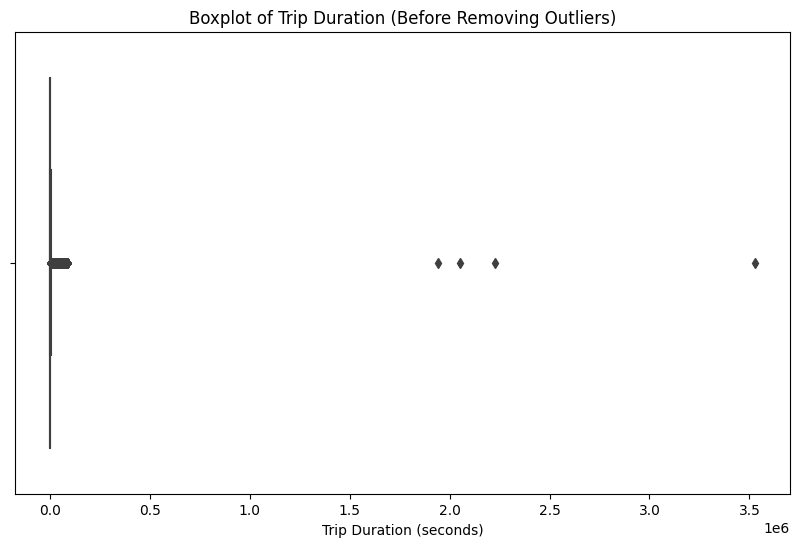


Interquartile Range (IQR): 678.0
Lower Bound: -620.0
Upper Bound: 2092.0
Number of Outliers: 74220 



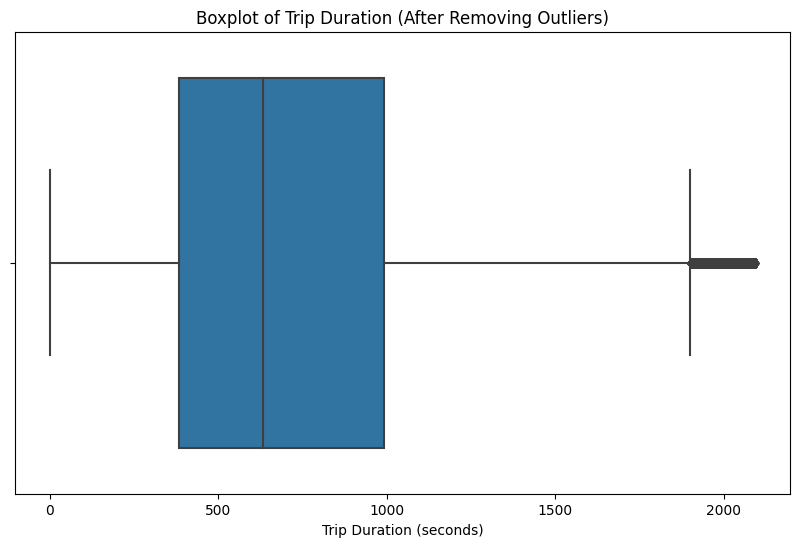

In [75]:
# Using CuPy for GPU acceleration
start_time_gpu = time.time()

# Convert the 'trip_duration' column of the existing 'train_gpu' DataFrame to a CuPy array
train_gpu_numpy = cp.array(train_gpu['trip_duration'])

# Plot boxplot for trip duration
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_gpu_numpy.get())  # Convert CuPy array to NumPy array explicitly
plt.title('Boxplot of Trip Duration (Before Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

# Calculate the interquartile range
Q1 = cp.percentile(train_gpu_numpy, 25)
Q3 = cp.percentile(train_gpu_numpy, 75)

IQR = Q3 - Q1

print('\nInterquartile Range (IQR):', IQR)

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

# Identify outliers
outliers = train_gpu_numpy[(train_gpu_numpy < lower_bound) | (train_gpu_numpy > upper_bound)]
print('Number of Outliers:', len(outliers), "\n")

# Remove outliers
train_gpu = train_gpu[(train_gpu['trip_duration'] >= lower_bound.get()) & (train_gpu['trip_duration'] <= upper_bound.get())]

# Convert the 'trip_duration' column of the modified 'train_gpu' DataFrame to a CuPy array
train_gpu_numpy2 = cp.array(train_gpu['trip_duration'])

# Plot boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_gpu_numpy2.get())  # Convert CuPy array to NumPy array explicitly
plt.title('Boxplot of Trip Duration (After Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

end_time_gpu = time.time()

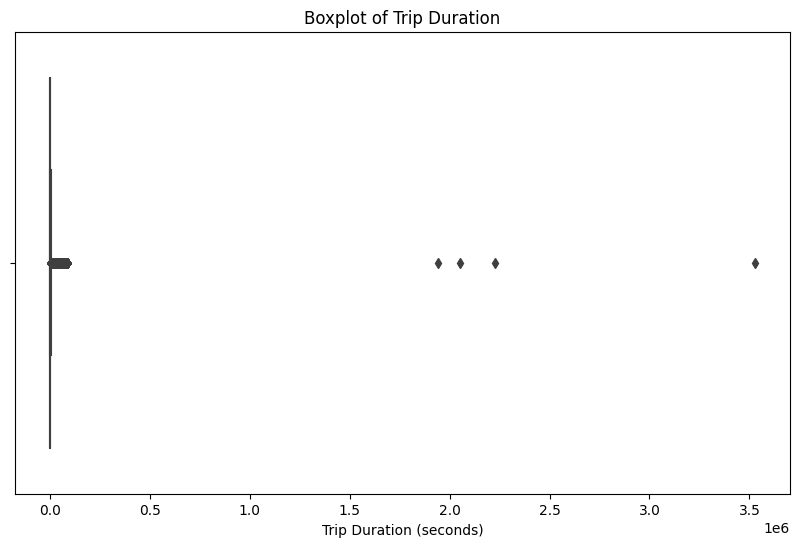


Interquartile Range (IQR): 678.0
Lower Bound: -620.0
Upper Bound: 2092.0
Number of Outliers: 74220 



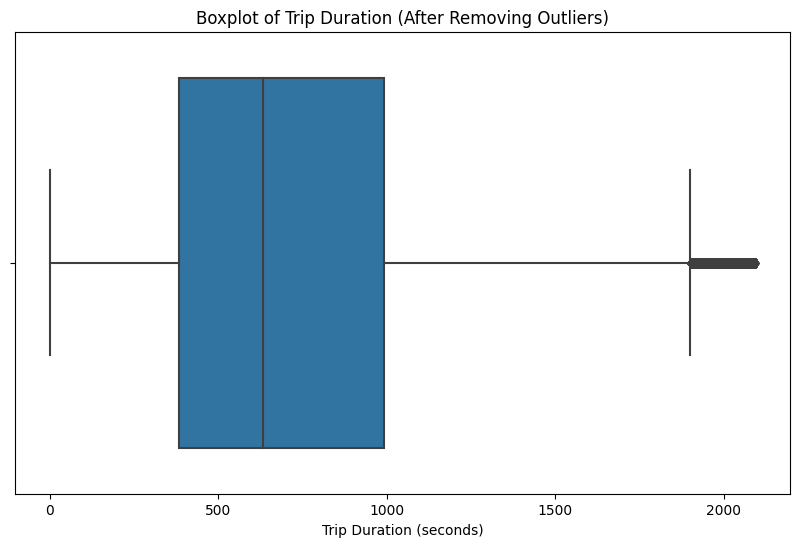

In [76]:
# using cpu
# plot boxplot for trip duration to identify outliers
# Plot boxplot for trip duration
start_time_cpu = time.time()

plt.figure(figsize=(10, 6))
sns.boxplot(x=train_cpu['trip_duration'])
plt.title('Boxplot of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.show()

# Calculate the interquartile range
Q1 = train_cpu['trip_duration'].quantile(0.25)
Q3 = train_cpu['trip_duration'].quantile(0.75)

IQR = Q3 - Q1

print('\nInterquartile Range (IQR):', IQR)

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

# Identify outliers
outliers = train_cpu[(train_cpu['trip_duration'] < lower_bound) | (train_cpu['trip_duration'] > upper_bound)]
print('Number of Outliers:', len(outliers), "\n")

# Remove outliers
train_cpu = train_cpu[(train_cpu['trip_duration'] >= lower_bound) & (train_cpu['trip_duration'] <= upper_bound)]

# boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_cpu['trip_duration'])
plt.title('Boxplot of Trip Duration (After Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

end_time_cpu = time.time()

In [77]:
# Display the time taken for outlier analysis using pandas
print("Time taken for outlier analysis using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for outlier analysis using cuDF
print("Time taken for outlier analysis using GUP: ", end_time_gpu - start_time_gpu)

Time taken for outlier analysis using pandas:  0.8130874633789062
Time taken for outlier analysis using GUP:  0.6998226642608643


The time taken for outlier analysis of the trip duration using the GPU is 0.69 seconds and the time taken for outlier analysis of the trip duration using the CPU is 0.81 seconds. The GPU did the process faster but it is not a significant difference from the CPU.

In [78]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Outlier Analysis Trip Duration', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Outlier Analysis Trip Duration', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# Outlier Analysis for the pickup latitude and longitude columns


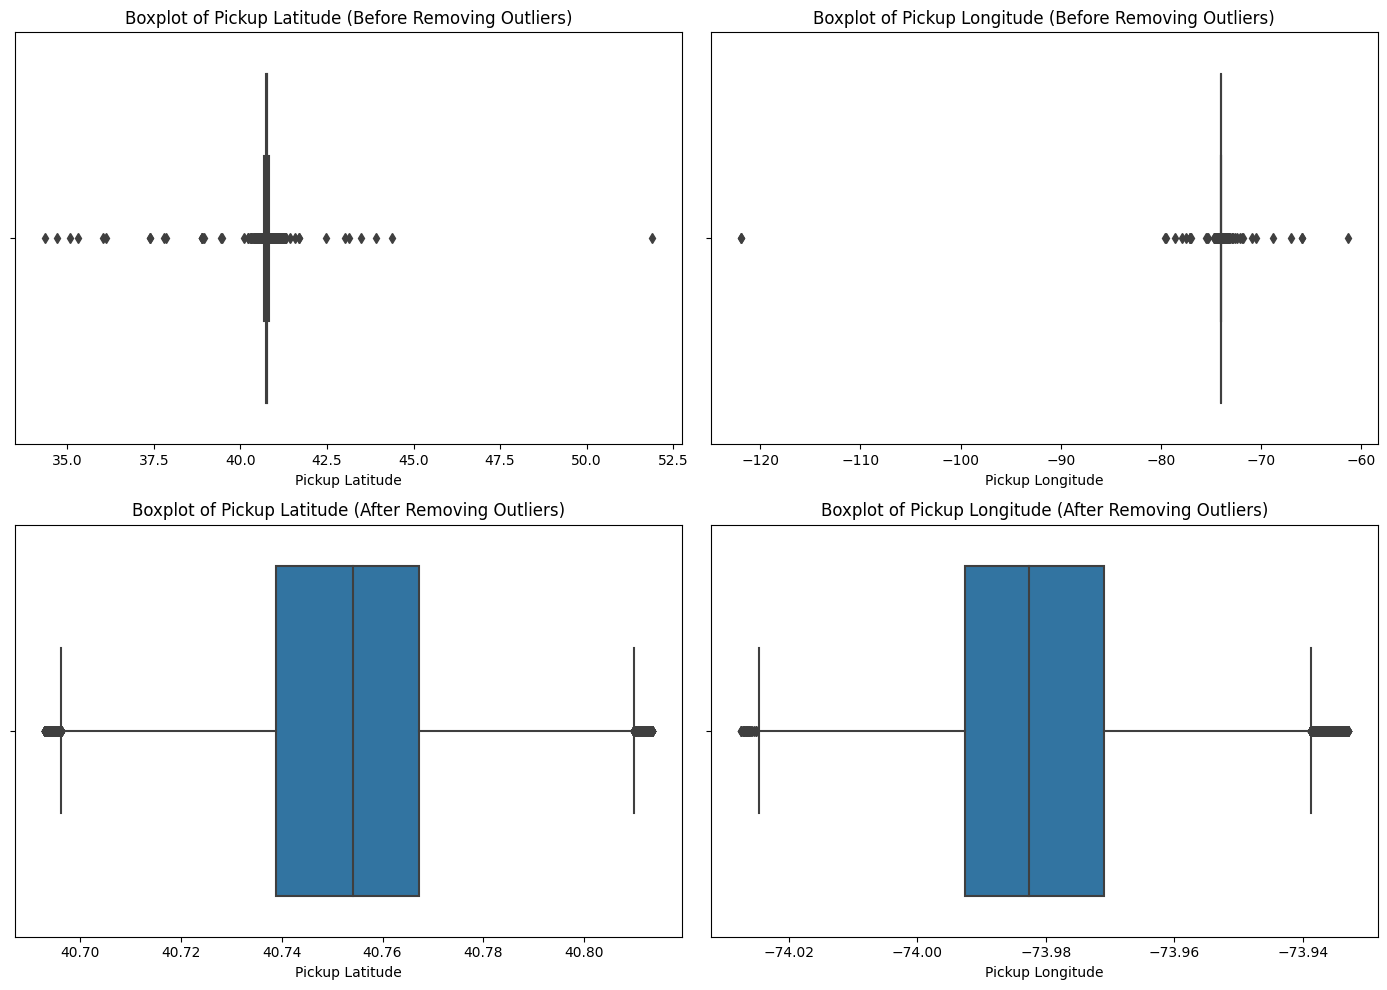

In [79]:
start_time_gpu = time.time()

# Convert the 'pickup_latitude' and 'pickup_longitude' columns of the existing 'train_gpu' DataFrame to CuPy arrays
pickup_latitude_gpu = cp.array(train_gpu['pickup_latitude'])
pickup_longitude_gpu = cp.array(train_gpu['pickup_longitude'])

# Create a 2x2 subplot grid
plt.figure(figsize=(14, 10))

# Plot boxplot for pickup latitude before removing outliers
plt.subplot(2, 2, 1)
sns.boxplot(x=pickup_latitude_gpu.get())  
plt.title('Boxplot of Pickup Latitude (Before Removing Outliers)')
plt.xlabel('Pickup Latitude')

# Plot boxplot for pickup longitude before removing outliers
plt.subplot(2, 2, 2)
sns.boxplot(x=pickup_longitude_gpu.get()) 
plt.title('Boxplot of Pickup Longitude (Before Removing Outliers)')
plt.xlabel('Pickup Longitude')

# Calculate the interquartile range (IQR) for pickup latitude and longitude
Q1_lat, Q3_lat = cp.percentile(pickup_latitude_gpu, [25, 75])
Q1_lon, Q3_lon = cp.percentile(pickup_longitude_gpu, [25, 75])

IQR_lat = Q3_lat - Q1_lat
IQR_lon = Q3_lon - Q1_lon

# Calculate the lower and upper bounds for pickup latitude and longitude
lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat

lower_bound_lon = Q1_lon - 1.5 * IQR_lon
upper_bound_lon = Q3_lon + 1.5 * IQR_lon

# Remove outliers
train_gpu = train_gpu[(train_gpu['pickup_latitude'] >= lower_bound_lat.get()) & (train_gpu['pickup_latitude'] <= upper_bound_lat.get())]
train_gpu = train_gpu[(train_gpu['pickup_longitude'] >= lower_bound_lon.get()) & (train_gpu['pickup_longitude'] <= upper_bound_lon.get())]

# Convert the 'pickup_latitude' and 'pickup_longitude' columns of the modified 'train_gpu' DataFrame to CuPy arrays
pickup_latitude_gpu2 = cp.array(train_gpu['pickup_latitude'])
pickup_longitude_gpu2 = cp.array(train_gpu['pickup_longitude'])

# Plot boxplot for pickup latitude after removing outliers
plt.subplot(2, 2, 3)
sns.boxplot(x=pickup_latitude_gpu2.get())  
plt.title('Boxplot of Pickup Latitude (After Removing Outliers)')
plt.xlabel('Pickup Latitude')

# Plot boxplot for pickup longitude after removing outliers
plt.subplot(2, 2, 4)
sns.boxplot(x=pickup_longitude_gpu2.get()) 
plt.title('Boxplot of Pickup Longitude (After Removing Outliers)')
plt.xlabel('Pickup Longitude')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

end_time_gpu = time.time()

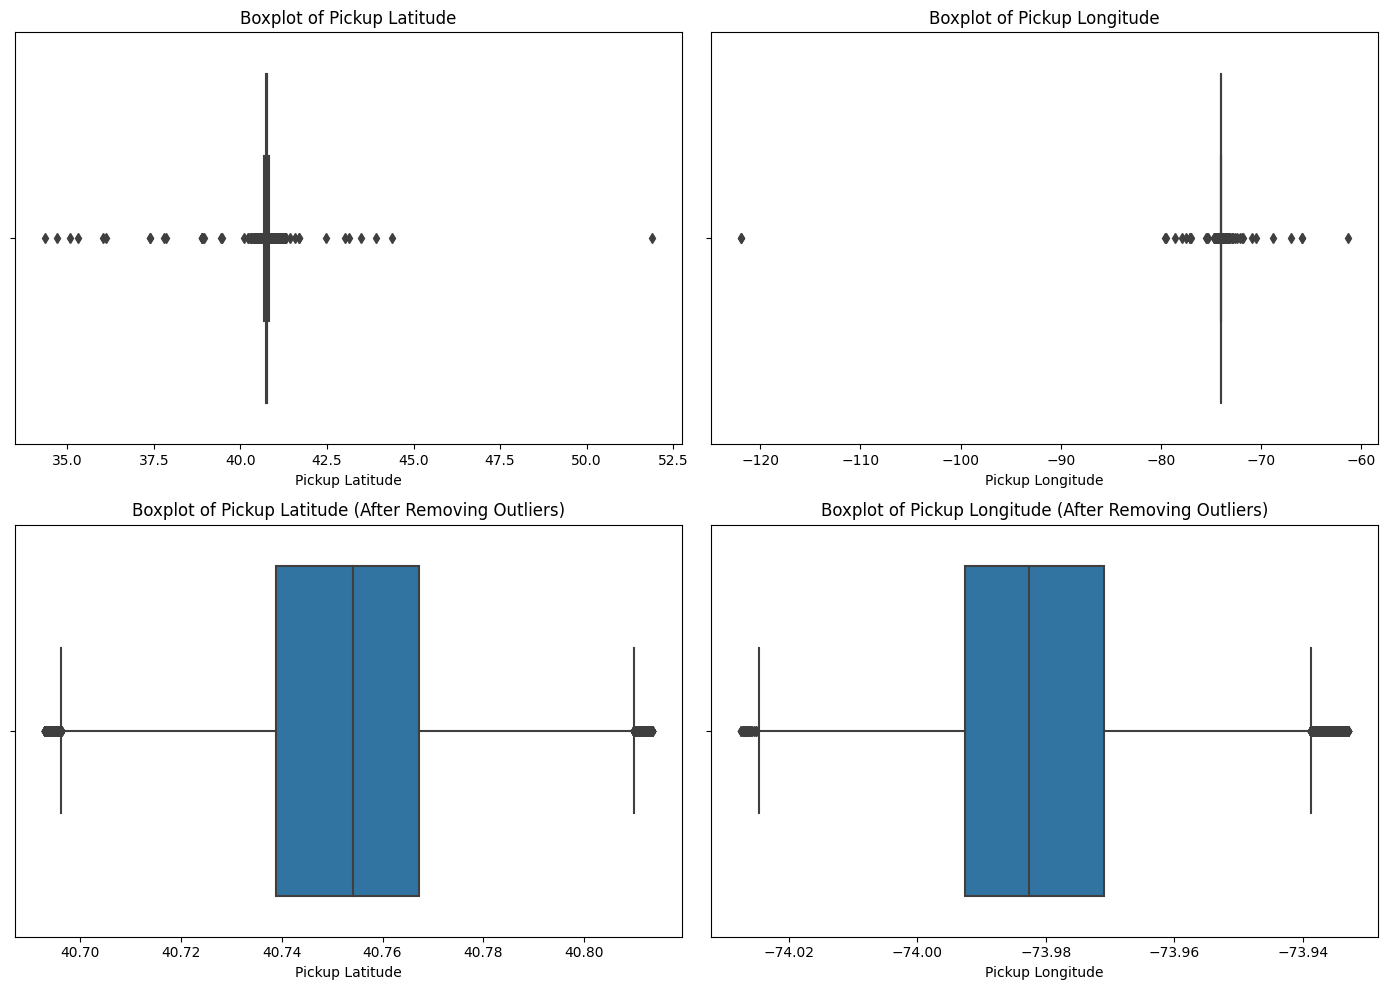

In [80]:
# Using pandas
# plot boxplot for pickup latitude and longitude to identify outliers
# Plot boxplot for pickup latitude

start_time_cpu = time.time()

# Create a 2x2 subplot grid
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x=train_cpu['pickup_latitude'])
plt.title('Boxplot of Pickup Latitude')
plt.xlabel('Pickup Latitude')

# Plot boxplot for pickup longitude
plt.subplot(2, 2, 2)
sns.boxplot(x=train_cpu['pickup_longitude'])
plt.title('Boxplot of Pickup Longitude')
plt.xlabel('Pickup Longitude')

# Calculate the interquartile range (IQR) for pickup latitude and longitude
Q1_lat, Q3_lat = train_cpu['pickup_latitude'].quantile([0.25, 0.75])
Q1_lon, Q3_lon = train_cpu['pickup_longitude'].quantile([0.25, 0.75])

IQR_lat = Q3_lat - Q1_lat
IQR_lon = Q3_lon - Q1_lon

# Calculate the lower and upper bounds for pickup latitude and longitude
lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat

lower_bound_lon = Q1_lon - 1.5 * IQR_lon
upper_bound_lon = Q3_lon + 1.5 * IQR_lon

# Remove outliers
train_cpu = train_cpu[(train_cpu['pickup_latitude'] >= lower_bound_lat) & (train_cpu['pickup_latitude'] <= upper_bound_lat)]
train_cpu = train_cpu[(train_cpu['pickup_longitude'] >= lower_bound_lon) & (train_cpu['pickup_longitude'] <= upper_bound_lon)]

# boxplot after removing outliers
plt.subplot(2, 2, 3)
sns.boxplot(x=train_cpu['pickup_latitude'])
plt.title('Boxplot of Pickup Latitude (After Removing Outliers)')
plt.xlabel('Pickup Latitude')

# boxplot after removing outliers
plt.subplot(2, 2, 4)
sns.boxplot(x=train_cpu['pickup_longitude'])
plt.title('Boxplot of Pickup Longitude (After Removing Outliers)')
plt.xlabel('Pickup Longitude')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

end_time_cpu = time.time()

In [81]:
# Display the time taken for outlier analysis using pandas
print("Time taken for outlier analysis using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for outlier analysis using cuDF
print("Time taken for outlier analysis using GUP: ", end_time_gpu - start_time_gpu)

Time taken for outlier analysis using pandas:  1.0958502292633057
Time taken for outlier analysis using GUP:  1.0889999866485596


Both the GPU and the CPU took approximately 1 second to run the outlier analysis for the Pickup Latitude and Longitude

In [82]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Outlier Analysis Pickup Latitude and Longitude', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Outlier Analysis Pickup Latitude and Longitude', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# outlier analysis for dropoff latitude and longitude columns


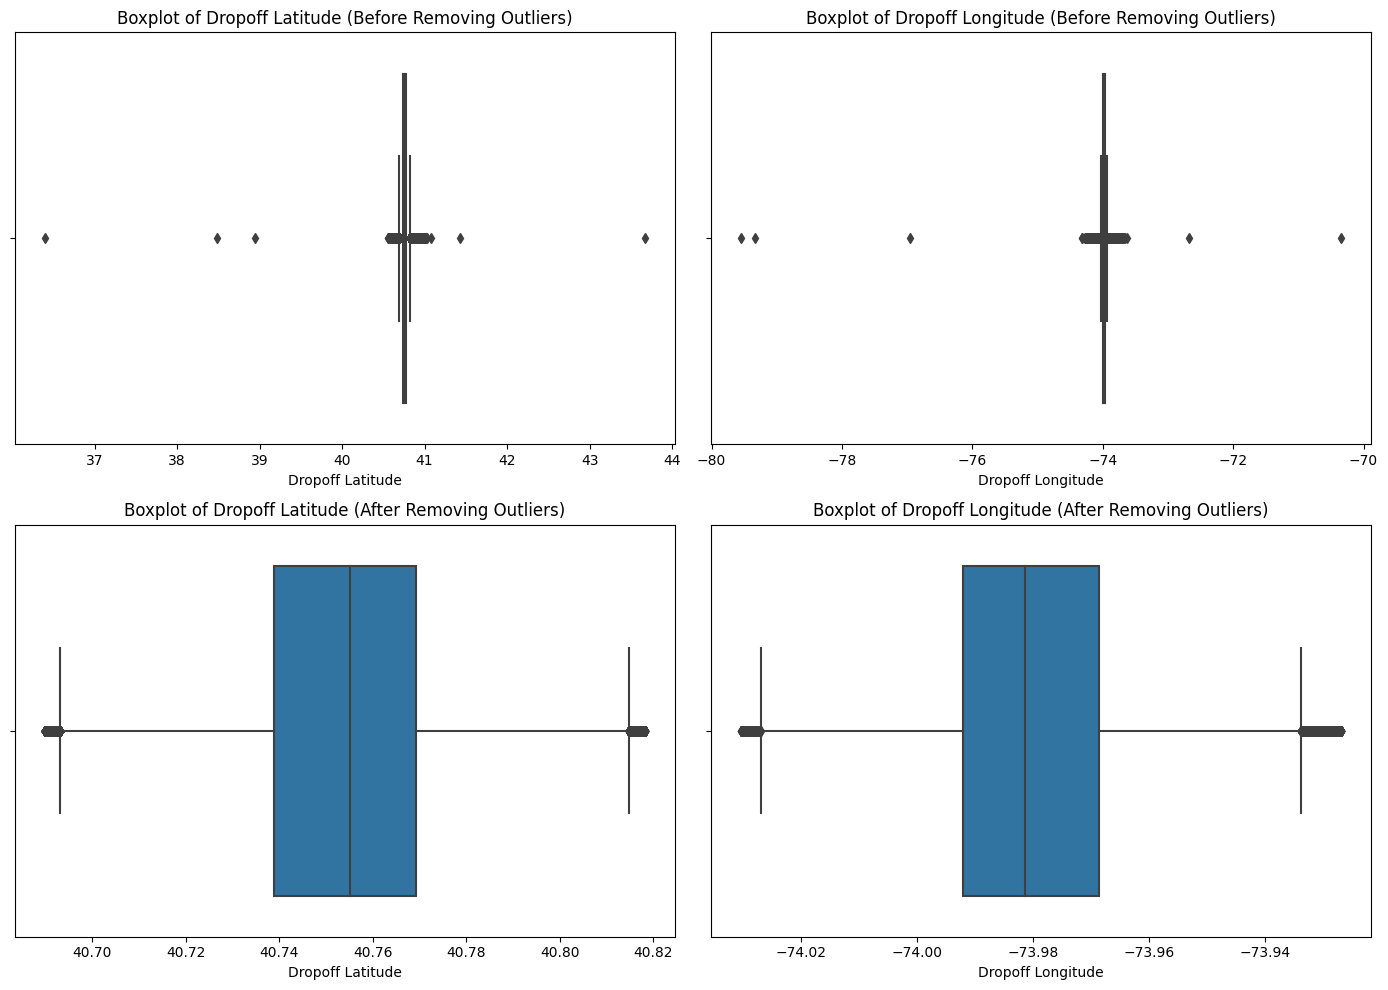

In [83]:
# Using CuPy for GPU acceleration
start_time_gpu = time.time()

# Convert the 'dropoff_latitude' and 'dropoff_longitude' columns of the existing 'train_gpu' DataFrame to CuPy arrays
dropoff_latitude_gpu = cp.array(train_gpu['dropoff_latitude'])
dropoff_longitude_gpu = cp.array(train_gpu['dropoff_longitude'])

# Create a 2x2 subplot grid
plt.figure(figsize=(14, 10))

# Plot boxplot for dropoff latitude before removing outliers
plt.subplot(2, 2, 1)
sns.boxplot(x=dropoff_latitude_gpu.get())  # No need to convert to NumPy explicitly
plt.title('Boxplot of Dropoff Latitude (Before Removing Outliers)')
plt.xlabel('Dropoff Latitude')

# Plot boxplot for dropoff longitude before removing outliers
plt.subplot(2, 2, 2)
sns.boxplot(x=dropoff_longitude_gpu.get())  # No need to convert to NumPy explicitly
plt.title('Boxplot of Dropoff Longitude (Before Removing Outliers)')
plt.xlabel('Dropoff Longitude')

# Calculate the interquartile range (IQR) for dropoff latitude and longitude
Q1_lat, Q3_lat = cp.percentile(dropoff_latitude_gpu, [25, 75])
Q1_lon, Q3_lon = cp.percentile(dropoff_longitude_gpu, [25, 75])

IQR_lat = Q3_lat - Q1_lat
IQR_lon = Q3_lon - Q1_lon

# Calculate the lower and upper bounds for dropoff latitude and longitude
lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat

lower_bound_lon = Q1_lon - 1.5 * IQR_lon
upper_bound_lon = Q3_lon + 1.5 * IQR_lon

train_gpu = train_gpu[(train_gpu['dropoff_latitude'] >= lower_bound_lat.get()) & (train_gpu['dropoff_latitude'] <= upper_bound_lat.get())]

train_gpu = train_gpu[(train_gpu['dropoff_longitude'] >= lower_bound_lon.get()) & (train_gpu['dropoff_longitude'] <= upper_bound_lon.get())]

# Convert the 'dropoff_latitude' and 'dropoff_longitude' columns of the modified 'train_gpu' DataFrame to CuPy arrays
dropoff_latitude_gpu2 = cp.array(train_gpu['dropoff_latitude'])

dropoff_longitude_gpu2 = cp.array(train_gpu['dropoff_longitude'])

# Plot boxplot for dropoff latitude after removing outliers
plt.subplot(2, 2, 3)
sns.boxplot(x=dropoff_latitude_gpu2.get())  # No need to convert to NumPy explicitly
plt.title('Boxplot of Dropoff Latitude (After Removing Outliers)')
plt.xlabel('Dropoff Latitude')

# Plot boxplot for dropoff longitude after removing outliers
plt.subplot(2, 2, 4)
sns.boxplot(x=dropoff_longitude_gpu2.get())  # No need to convert to NumPy explicitly
plt.title('Boxplot of Dropoff Longitude (After Removing Outliers)')
plt.xlabel('Dropoff Longitude')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

end_time_gpu = time.time()

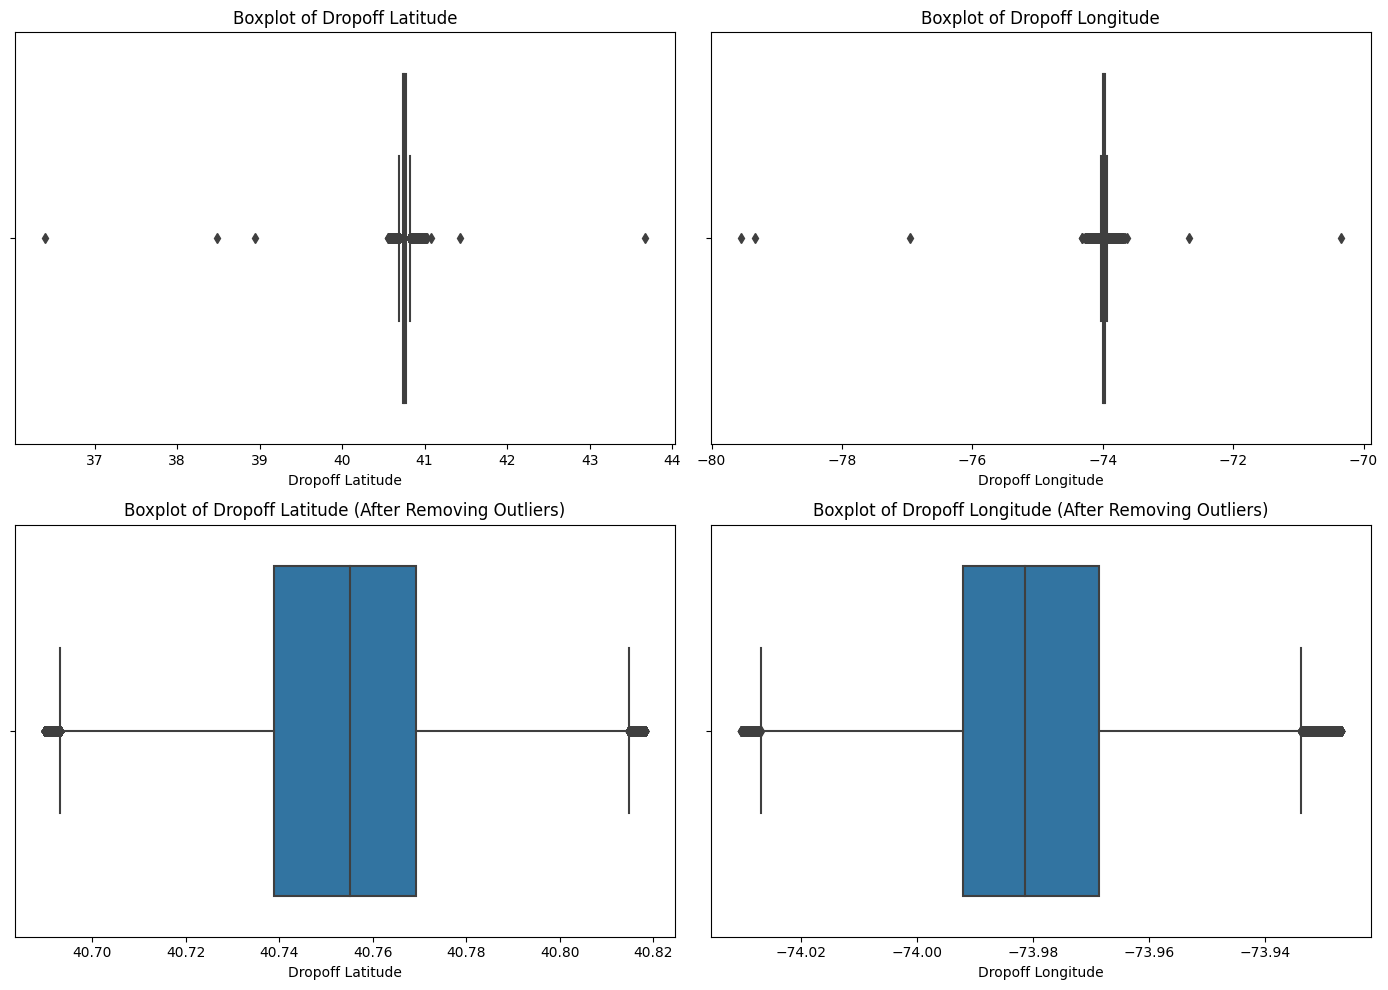

In [84]:
# Using pandas
# plot boxplot for dropoff latitude and longitude to identify outliers
# Plot boxplot for dropoff latitude
start_time_cpu = time.time()

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x=train_cpu['dropoff_latitude'])
plt.title('Boxplot of Dropoff Latitude')
plt.xlabel('Dropoff Latitude')


# Plot boxplot for dropoff longitude
plt.subplot(2, 2, 2)
sns.boxplot(x=train_cpu['dropoff_longitude'])
plt.title('Boxplot of Dropoff Longitude')
plt.xlabel('Dropoff Longitude')

# Calculate the interquartile range (IQR) for dropoff latitude and longitude
Q1_lat, Q3_lat = train_cpu['dropoff_latitude'].quantile([0.25, 0.75])
Q1_lon, Q3_lon = train_cpu['dropoff_longitude'].quantile([0.25, 0.75])

IQR_lat = Q3_lat - Q1_lat
IQR_lon = Q3_lon - Q1_lon

# Calculate the lower and upper bounds for dropoff latitude and longitude
lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat

lower_bound_lon = Q1_lon - 1.5 * IQR_lon
upper_bound_lon = Q3_lon + 1.5 * IQR_lon

# Remove outliers
train_cpu =  train_cpu[(train_cpu['dropoff_latitude'] >= lower_bound_lat) & (train_cpu['dropoff_latitude'] <= upper_bound_lat)]
train_cpu =  train_cpu[(train_cpu['dropoff_longitude'] >= lower_bound_lon) & (train_cpu['dropoff_longitude'] <= upper_bound_lon)]

# boxplot after removing outliers
plt.subplot(2, 2, 3)
sns.boxplot(x=train_cpu['dropoff_latitude'])
plt.title('Boxplot of Dropoff Latitude (After Removing Outliers)')
plt.xlabel('Dropoff Latitude')

# boxplot after removing outliers
plt.subplot(2, 2, 4)
sns.boxplot(x=train_cpu['dropoff_longitude'])
plt.title('Boxplot of Dropoff Longitude (After Removing Outliers)')
plt.xlabel('Dropoff Longitude')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

end_time_cpu = time.time()

In [85]:
# Display the time taken for outlier analysis using pandas
print("Time taken for outlier analysis using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for outlier analysis using cuDF
print("Time taken for outlier analysis using GUP: ", end_time_gpu - start_time_gpu)

Time taken for outlier analysis using pandas:  1.1826951503753662
Time taken for outlier analysis using GUP:  0.9738321304321289


Both the GPU and the CPU took approximately 1 second to run the outlier analysis for the Dropoff Latitude and Longitude

In [86]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Outlier Analysis Dropoff Latitude and Longitude', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Outlier Analysis Dropoff Latitude and Longitude', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# (b) Conduct basic exploratory data analysis (EDA) with both CPU-based tools (e.g., matplotlib) and GPU-accelerated tools, noting any differences in performance and responsiveness.


In [87]:
data_pandas = train_gpu.to_pandas()
trip_duration_pandas = train_gpu['trip_duration'].to_pandas()

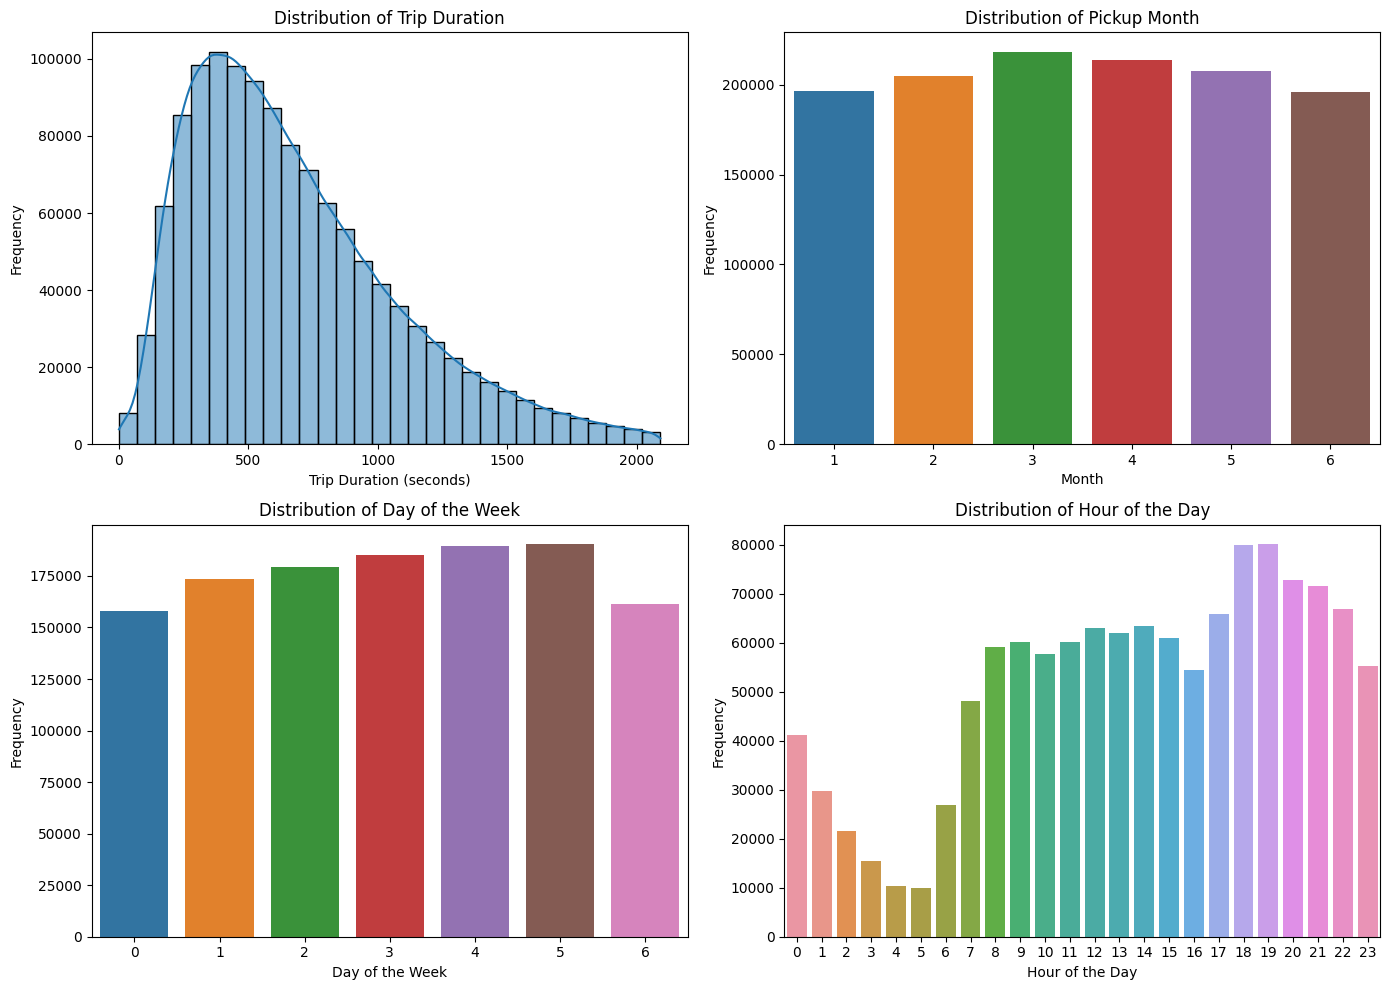

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.236724e+06     1.236724e+06      1.236724e+06     1.236724e+06   
mean   1.532825e+00     1.660446e+00     -7.398157e+01     4.075339e+01   
std    4.989215e-01     1.312348e+00      1.621725e-02     2.123570e-02   
min    1.000000e+00     0.000000e+00     -7.402742e+01     4.069304e+01   
25%    1.000000e+00     1.000000e+00     -7.399253e+01     4.073922e+01   
50%    2.000000e+00     1.000000e+00     -7.398252e+01     4.075438e+01   
75%    2.000000e+00     2.000000e+00     -7.397102e+01     4.076743e+01   
max    2.000000e+00     6.000000e+00     -7.393304e+01     4.081344e+01   

       dropoff_longitude  dropoff_latitude  pickup_month    pickup_day  \
count       1.236724e+06      1.236724e+06  1.236724e+06  1.236724e+06   
mean       -7.398018e+01      4.075389e+01  3.500044e+00  3.044307e+00   
std         1.741610e-02      2.321283e-02  1.679696e+00  1.948047e+00   
min        -7.403043e+01    

In [88]:
# EDA using GPU
# use seaborn to plot the distribution of the trip duration

start_time_gpu = time.time()

# Create a 2x2 subplot grid
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(trip_duration_pandas, bins=30, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')

# plot the distribution of the pickup month
plt.subplot(2, 2, 2)
sns.countplot(x='pickup_month', data=data_pandas)
plt.title('Distribution of Pickup Month')
plt.xlabel('Month')
plt.ylabel('Frequency')

# plot the distribution of the day of the week
plt.subplot(2, 2, 3)
sns.countplot(x='pickup_day', data=data_pandas)
plt.title('Distribution of Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')

# plot the distribution of the hour of the day
plt.subplot(2, 2, 4)
sns.countplot(x='pickup_hour', data=data_pandas)
plt.title('Distribution of Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

print(train_cpu.describe())

end_time_gpu = time.time()


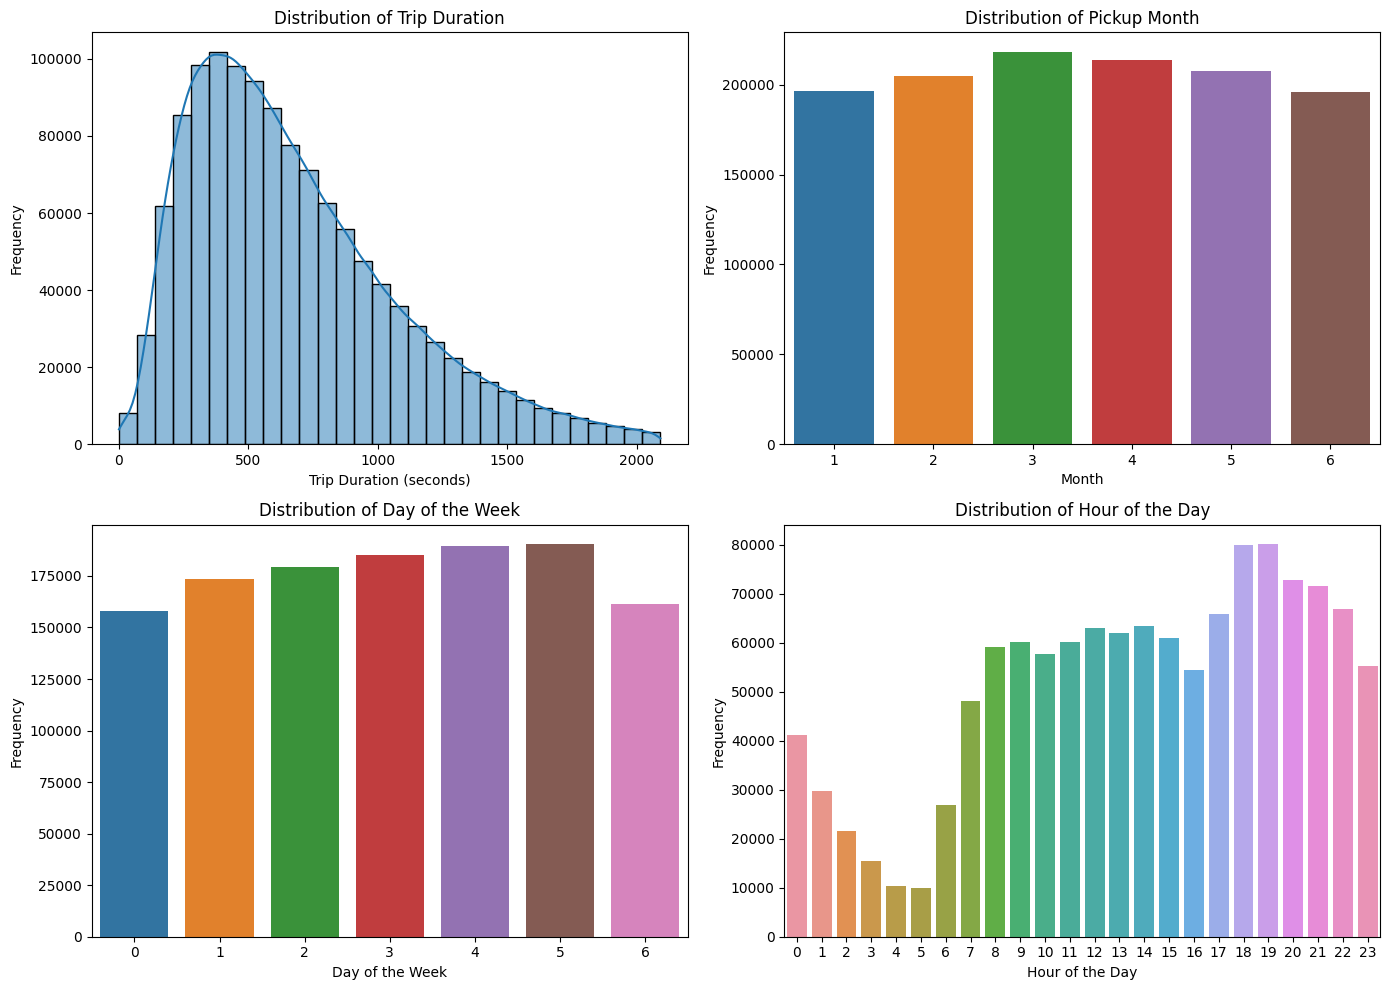

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.236724e+06     1.236724e+06      1.236724e+06     1.236724e+06   
mean   1.532825e+00     1.660446e+00     -7.398157e+01     4.075339e+01   
std    4.989215e-01     1.312348e+00      1.621725e-02     2.123570e-02   
min    1.000000e+00     0.000000e+00     -7.402742e+01     4.069304e+01   
25%    1.000000e+00     1.000000e+00     -7.399253e+01     4.073922e+01   
50%    2.000000e+00     1.000000e+00     -7.398252e+01     4.075438e+01   
75%    2.000000e+00     2.000000e+00     -7.397102e+01     4.076743e+01   
max    2.000000e+00     6.000000e+00     -7.393304e+01     4.081344e+01   

       dropoff_longitude  dropoff_latitude  pickup_month    pickup_day  \
count       1.236724e+06      1.236724e+06  1.236724e+06  1.236724e+06   
mean       -7.398018e+01      4.075389e+01  3.500044e+00  3.044307e+00   
std         1.741610e-02      2.321283e-02  1.679696e+00  1.948047e+00   
min        -7.403043e+01    

In [89]:
# use seaborn to plot the distribution of the trip duration
start_time_cpu = time.time()

# Create a 2x2 subplot grid
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(train_cpu['trip_duration'], bins=30, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')

# plot the distribution of the pickup month
plt.subplot(2, 2, 2)
sns.countplot(x='pickup_month', data=train_cpu)
plt.title('Distribution of Pickup Month')
plt.xlabel('Month')
plt.ylabel('Frequency')

# plot the distribution of the day of the week
plt.subplot(2, 2, 3)
sns.countplot(x='pickup_day', data=train_cpu)
plt.title('Distribution of Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')

# plot the distribution of the hour of the day
plt.subplot(2, 2, 4)
sns.countplot(x='pickup_hour', data=train_cpu)
plt.title('Distribution of Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

print(train_cpu.describe())

end_time_cpu = time.time()

In [90]:
# Display the time taken for EDA using pandas
print("Time taken for EDA using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for EDA using cuDF
print("Time taken for EDA using GUP: ", end_time_gpu - start_time_gpu)

Time taken for EDA using pandas:  7.106843709945679
Time taken for EDA using GUP:  7.226229190826416


Both the GPU and the CPU took approximately 7 seconds to run the EDA

In [91]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['EDA', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['EDA', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# 2. Feature Engineering and Selection


# (a) Engage in feature engineering, creating new variables that could aid in predicting trip durations. Compare the execution time for these operations on CPU vs. GPU.


In [92]:
# Calculate the haversine distance between pickup and dropoff coordinates
def calculate_distance_GPU(lat1, lon1, lat2, lon2):
    lat1 = cp.radians(lat1)
    lon1 = cp.radians(lon1)
    lat2 = cp.radians(lat2)
    lon2 = cp.radians(lon2)

    R = 6371 # earth radius in meters

    delta_phi = lat2 - lat1
    delta_lambda = lon2 - lon1

    a = cp.sin(delta_phi / 2.0)**2 + cp.cos(lat1) * cp.cos(lat2) * cp.sin(delta_lambda / 2.0)**2
    c = 2 * cp.arctan2(cp.sqrt(a), cp.sqrt(1 - a))

    return R * c

def calculate_distance_CPU(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    R = 6371 # earth radius in meters

    delta_phi = lat2 - lat1
    delta_lambda = lon2 - lon1

    a = np.sin(delta_phi / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

def calculate_bearing_GPU(lat1, lon1, lat2, lon2):
    lat1 = cp.radians(lat1)
    lon1 = cp.radians(lon1)
    lat2 = cp.radians(lat2)
    lon2 = cp.radians(lon2)

    delta_lambda = lon2 - lon1

    y = cp.sin(delta_lambda) * cp.cos(lat2)
    x = cp.cos(lat1) * cp.sin(lat2) - cp.sin(lat1) * cp.cos(lat2) * cp.cos(delta_lambda)

    return cp.degrees(cp.arctan2(y, x))

def calculate_bearing_CPU(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    delta_lambda = lon2 - lon1

    y = np.sin(delta_lambda) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lambda)

    return np.degrees(np.arctan2(y, x))



In [98]:
# Feature Engineering using cuDF
# create a new column for the distance of the trip
# create a new column for the distance and direction of the trip
time_start_gpu = time.time()

train_gpu['distance'] = calculate_distance_GPU(train_gpu['pickup_latitude'], train_gpu['pickup_longitude'], train_gpu['dropoff_latitude'], train_gpu['dropoff_longitude'])
test_gpu['distance'] = calculate_distance_GPU(test_gpu['pickup_latitude'], test_gpu['pickup_longitude'], test_gpu['dropoff_latitude'], test_gpu['dropoff_longitude'])

train_gpu['direction'] = calculate_bearing_GPU(train_gpu['pickup_latitude'], train_gpu['pickup_longitude'], train_gpu['dropoff_latitude'], train_gpu['dropoff_longitude'])
test_gpu['direction'] = calculate_bearing_GPU(test_gpu['pickup_latitude'], test_gpu['pickup_longitude'], test_gpu['dropoff_latitude'], test_gpu['dropoff_longitude'])

end_time_gpu = time.time()

In [99]:
# Feature Engineering using pandas 
# create a new column for the distance of the trip

time_start_cpu = time.time()

train_cpu['distance'] = calculate_distance_CPU(train_cpu['pickup_latitude'], train_cpu['pickup_longitude'], train_cpu['dropoff_latitude'], train_cpu['dropoff_longitude'])
test_cpu['distance'] = calculate_distance_CPU(test_cpu['pickup_latitude'], test_cpu['pickup_longitude'], test_cpu['dropoff_latitude'], test_cpu['dropoff_longitude'])

train_cpu['direction'] = calculate_bearing_CPU(train_cpu['pickup_latitude'], train_cpu['pickup_longitude'], train_cpu['dropoff_latitude'], train_cpu['dropoff_longitude'])
test_cpu['direction'] = calculate_bearing_CPU(test_cpu['pickup_latitude'], test_cpu['pickup_longitude'], test_cpu['dropoff_latitude'], test_cpu['dropoff_longitude'])

end_time_cpu = time.time()

In [100]:
# Display the time taken for feature engineering using pandas
print("Time taken for feature engineering using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for feature engineering using cuDF
print("Time taken for feature engineering using GUP: ", end_time_gpu - time_start_gpu)

Time taken for feature engineering using pandas:  0.3014707565307617
Time taken for feature engineering using GUP:  0.0660855770111084


The time taken to add the features using GPU is 0.67 seconds and the time taken to add the features using CPU is 0.3 sceonds. The GPU is significantly faster than the CPU when adding the features

In [101]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Feature Engineering', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Feature Engineering', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [102]:
train_gpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day,pickup_hour,trip_duration,distance,direction
0,2,1,-73.982155,40.767937,-73.964630,40.765602,3,0,17,455,1.498521,99.970196
1,1,1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,663,1.805507,-117.153768
3,2,1,-74.010040,40.719971,-74.012268,40.706718,4,2,19,429,1.485498,-172.737700
4,2,1,-73.973053,40.793209,-73.972923,40.782520,3,5,13,435,1.188588,179.473585
5,2,6,-73.982857,40.742195,-73.992081,40.749184,1,5,22,443,1.098942,-44.995596


In [103]:
test_gpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour,distance,direction
0,1,1,-73.988129,40.732029,-73.990173,40.756680,N,6,3,23,2.746426,-3.595224
1,1,1,-73.964203,40.679993,-73.959808,40.655403,N,6,3,23,2.759239,172.278835
2,1,1,-73.997437,40.737583,-73.986160,40.729523,N,6,3,23,1.306155,133.326248
3,2,1,-73.956070,40.771900,-73.986427,40.730469,N,6,3,23,5.269088,-150.956833
4,1,1,-73.970215,40.761475,-73.961510,40.755890,N,6,3,23,0.960842,130.260381


In [104]:
train_cpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day,pickup_hour,trip_duration,distance,direction
0,2,1,-73.982155,40.767937,-73.964630,40.765602,3,0,17,455,1.498521,99.970196
1,1,1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,663,1.805507,-117.153768
3,2,1,-74.010040,40.719971,-74.012268,40.706718,4,2,19,429,1.485498,-172.737700
4,2,1,-73.973053,40.793209,-73.972923,40.782520,3,5,13,435,1.188588,179.473585
5,2,6,-73.982857,40.742195,-73.992081,40.749184,1,5,22,443,1.098942,-44.995596


In [105]:
test_cpu.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour,distance,direction
0,1,1,-73.988129,40.732029,-73.990173,40.756680,N,6,3,23,2.746426,-3.595224
1,1,1,-73.964203,40.679993,-73.959808,40.655403,N,6,3,23,2.759239,172.278835
2,1,1,-73.997437,40.737583,-73.986160,40.729523,N,6,3,23,1.306155,133.326248
3,2,1,-73.956070,40.771900,-73.986427,40.730469,N,6,3,23,5.269088,-150.956833
4,1,1,-73.970215,40.761475,-73.961510,40.755890,N,6,3,23,0.960842,130.260381


# (b) Select relevant features for the model based on their correlation with the target variable, assessing the speed of these operations on CPU and GPU

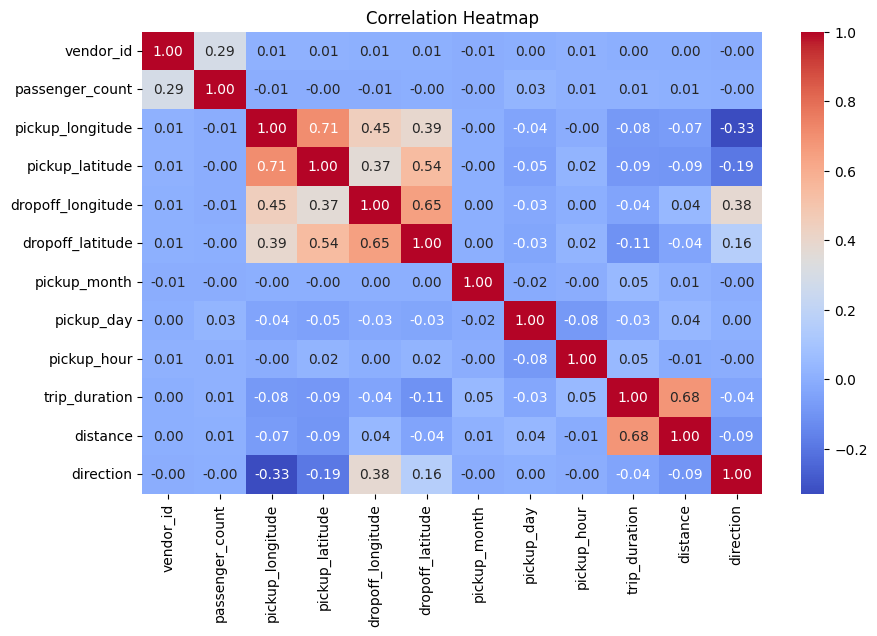

In [107]:
# Feature Selection using cuDF
# calculate the correlation between the features and the target variable trip_duration
time_start_gpu = time.time()

correlation_gpu = train_gpu.corr()['trip_duration']
# print corelation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train_gpu.corr().to_pandas(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

end_time_gpu = time.time()

In [108]:
correlation_gpu

vendor_id            0.001414
passenger_count      0.011924
pickup_longitude    -0.083585
pickup_latitude     -0.086984
dropoff_longitude   -0.040261
dropoff_latitude    -0.105856
pickup_month         0.049384
pickup_day          -0.032737
pickup_hour          0.048193
trip_duration        1.000000
distance             0.681994
direction           -0.043384
Name: trip_duration, dtype: float64

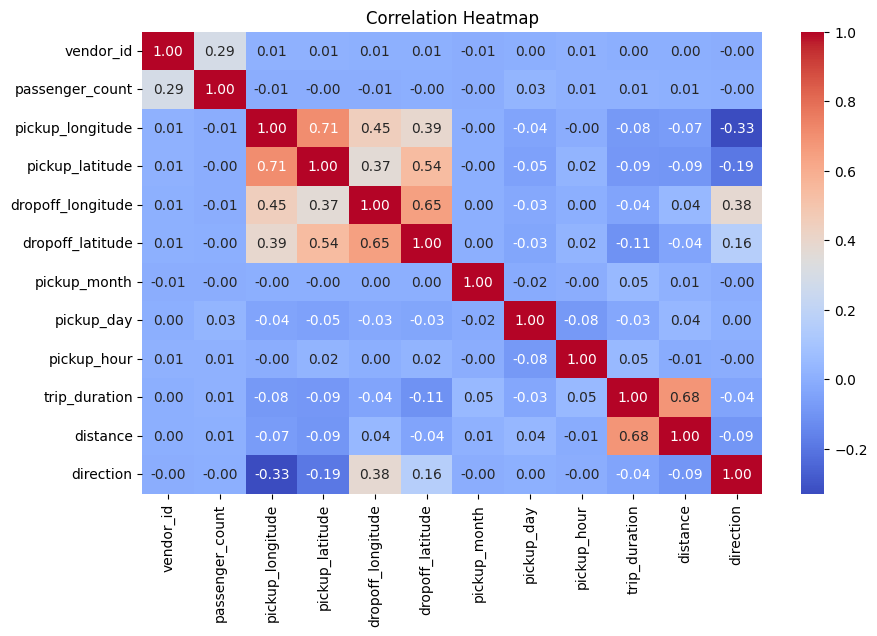

In [109]:
# Feature Selection using pandas
# calculate the correlation between the features and the target variable trip_duration
time_start_cpu = time.time()

correlation_cpu = train_cpu.corr()['trip_duration']

# print corelation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train_cpu.corr(), annot=True, cmap='coolwarm', fmt=".2f")   
plt.title('Correlation Heatmap')
plt.show()

end_time_cpu = time.time()

In [110]:
correlation_cpu

vendor_id            0.001414
passenger_count      0.011924
pickup_longitude    -0.083585
pickup_latitude     -0.086984
dropoff_longitude   -0.040261
dropoff_latitude    -0.105856
pickup_month         0.049384
pickup_day          -0.032737
pickup_hour          0.048193
trip_duration        1.000000
distance             0.681994
direction           -0.043384
Name: trip_duration, dtype: float64

The choosen features based on the correlation values are:
- distance
- dropoff_longitude
- dropoff_latitude
- pickup_longitude
- pickup_latitude
- pickup_hour   
- pickup_month
- pickup_day

In [111]:
# Display the time taken for Correlation Analysis using pandas
print("Time taken for Correlation Analysis using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for Correlation Analysis using cuDF
print("Time taken for Correlation Analysis using GUP: ", end_time_gpu - time_start_gpu)

Time taken for Correlation Analysis using pandas:  1.7058680057525635
Time taken for Correlation Analysis using GUP:  0.9693844318389893


The time taken for the correlation analysis using the GPU is 0.9 seconds and the time taken for correlation analysis using using the CPU is 1.7 seconds. The GPU is significantly faster than the CPU for the correlation analysis using

In [112]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Correlation Analysis', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Correlation Analysis', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [113]:
# create a new dataframe with only the selected features for both the training and test sets using cuDF
time_start_gpu = time.time()

train_gpu_feature = train_gpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day', 'trip_duration']]
test_gpu_feature = test_gpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day']]

end_time_gpu = time.time()

In [114]:
# create a new dataframe with only the selected features for both the training and test sets using pandas

time_start_cpu = time.time()

train_cpu_feature = train_cpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day', 'trip_duration']]
test_cpu_feature = test_cpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day']]

end_time_cpu = time.time()

In [115]:
# Display the time taken for feature selection using pandas
print("Time taken for feature selection using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for feature selection using cuDF
print("Time taken for feature selection using GUP: ", end_time_gpu - time_start_gpu)

Time taken for feature selection using pandas:  0.03697609901428223
Time taken for feature selection using GUP:  0.0011820793151855469


The time taken for the feature selection is 0.0012 seconds using the GPU and 0.037 seconds using the CPU. The GPU was significantly faster at the feature selection than the CPU

In [116]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Feature Selection', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Feature Selection', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [117]:
cpu_metrics

,Task,start_time,end_time,time_taken
0,Data Loading,1.713831e+09,1.713831e+09,5.760359
1,Data Preprocessing,1.713831e+09,1.713831e+09,2.494035
2,Outlier Analysis Trip Duration,1.713831e+09,1.713831e+09,0.813087
3,Outlier Analysis Pickup Latitude and Longitude,1.713831e+09,1.713831e+09,1.095850
4,Outlier Analysis Dropoff Latitude and Longitude,1.713831e+09,1.713831e+09,1.182695
5,EDA,1.713831e+09,1.713831e+09,7.106844
6,Feature Engineering,1.713831e+09,1.713831e+09,0.301471
7,Correlation Analysis,1.713831e+09,1.713831e+09,1.705868
8,Feature Selection,1.713831e+09,1.713831e+09,0.036976


In [118]:
gpu_metrics

,Task,start_time,end_time,time_taken
0,Data Loading,1.713831e+09,1.713831e+09,0.256687
1,Data Preprocessing,1.713831e+09,1.713831e+09,0.062975
2,Outlier Analysis Trip Duration,1.713831e+09,1.713831e+09,0.699823
3,Outlier Analysis Pickup Latitude and Longitude,1.713831e+09,1.713831e+09,1.089000
4,Outlier Analysis Dropoff Latitude and Longitude,1.713831e+09,1.713831e+09,0.973832
5,EDA,1.713831e+09,1.713831e+09,7.226229
6,Feature Engineering,1.713831e+09,1.713831e+09,0.066086
7,Correlation Analysis,1.713831e+09,1.713831e+09,0.969384
8,Feature Selection,1.713831e+09,1.713831e+09,0.001182


# 3. Model Training and Evaluation


# (a) Train a Gradient Boosting Machine (GBM) model on the dataset using scikit-learn (CPU) and cuML (GPU). Record and compare the training times.


In [119]:
# Model Training using cuML

inputs_gpu = train_gpu_feature.drop('trip_duration', axis=1)
targer_gpu = train_gpu_feature['trip_duration']

X_gpu = inputs_gpu.values
y_gpu = targer_gpu.values

# Split the data into training and testing sets
X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu = train_test_split(X_gpu, y_gpu, test_size=0.2, random_state=42)

# Train the Gradient Boosting Machine model using cuML
start_time_gpu = time.time()

gbm_gpu = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
gbm_gpu.fit(X_train_gpu, y_train_gpu)
#y_pred_gpu = gbm_gpu.predict(X_train_gpu_reshaped)

end_time_gpu = time.time()

In [120]:
# Model Training using scikit-learn

inputs_cpu = train_cpu_feature.drop('trip_duration', axis=1)
targer_cpu = train_cpu_feature['trip_duration']

X_cpu = inputs_cpu.values
y_cpu = targer_cpu.values

# Split the data into training and testing sets
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(X_cpu, y_cpu, test_size=0.2, random_state=42)

# Train the Gradient Boosting Machine model using scikit-learn

start_time_cpu = time.time()

gbm_cpu = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
gbm_cpu.fit(X_train_cpu, y_train_cpu)
#y_pred_cpu = gbm_cpu.predict(X_train_cpu)

end_time_cpu = time.time()

In [121]:
# Display the time taken for model training using scikit-learn
print("Time taken for model training using scikit-learn: ", end_time_cpu - start_time_cpu)
# Display the time taken for model training using cuML
print("Time taken for model training using cuML: ", end_time_gpu - start_time_gpu)

Time taken for model training using scikit-learn:  355.5254590511322
Time taken for model training using cuML:  3.344944953918457


The time taken to train the model using GPU is 3.34 seconds and the time taken to train the model using CPU is 355.52 seconds. The GPU is 104 times faster than he CPU at model training

In [122]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Model Training', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Model Training', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# (b) Evaluate the accuracy of both models and document the time taken for predictions on the test set using CPU and GPU.


In [123]:
# Model Evaluation using xgboost
# Evaluate the model on the test set

start_time_gpu = time.time()

# evaluate the model on the test data
predictions_gpu = gbm_gpu.predict(X_test_gpu)

# output the first 5 predictions
print('Predictions:', predictions_gpu[:5])

# Model Evaluation using xgboost
# Evaluate the model on the test set

start_time_gpu = time.time()

# Convert Cupy arrays to NumPy arrays
y_test_numpy = cp.asnumpy(y_test_gpu)
predictions_numpy = cp.asnumpy(predictions_gpu)

# Calculate the mean squared error
mean_squared_error_gpu = mean_squared_error(y_test_numpy, predictions_numpy)
print('Mean Squared Error (GPU):', mean_squared_error_gpu)

# calculate the R-squared value
r_squared_gpu = r2_score(y_test_numpy, predictions_numpy)
print('R-squared (GPU):', r_squared_gpu)

end_time_gpu = time.time()


Predictions: [ 606.79346  878.63666 1265.083    949.24475  740.1564 ]
Mean Squared Error (GPU): 52604.54409477839
R-squared (GPU): 0.6785341464199204


In [124]:
# Model Evaluation using scikit-learn
# Evaluate the model on the test set

# evaluate the model on the test data

predictions_cpu = gbm_cpu.predict(X_test_cpu)

# output the first 5 predictions
print('Predictions:', predictions_cpu[:5])

# Model Evaluation using scikit-learn
# Evaluate the model on the test set

start_time_cpu = time.time()

# Calculate the mean squared error
mean_squared_error_cpu = mean_squared_error(y_test_cpu, predictions_cpu)
print('Mean Squared Error (CPU):', mean_squared_error_cpu)

# calculate the R-squared value
r_squared_cpu = r2_score(y_test_cpu, predictions_cpu)
print('R-squared (CPU):', r_squared_cpu)

end_time_cpu = time.time()

Predictions: [ 597.21155133  870.02915513 1305.00701095  976.4224952   721.32601043]
Mean Squared Error (CPU): 52555.91664706254
R-squared (CPU): 0.6788313082764936


In [125]:
# Display the time taken for model evaluation using scikit-learn
print("Time taken for model evaluation using scikit-learn: ", end_time_cpu - start_time_cpu)
# Display the time taken for model evaluation using cuML
print("Time taken for model evaluation using cuML: ", end_time_gpu - start_time_gpu)

Time taken for model evaluation using scikit-learn:  0.0037412643432617188
Time taken for model evaluation using cuML:  0.004321575164794922


Both the GPU and the CPU took approximately 0.004 second to evaluate the models. The MSE for the CPU model is 52555 and the MSE for the GPU modle is 52604. There is no significant different in terms of MSE for both models. The R^2 value for both the GPU and the CPU models are approximately 0.68. This means that only 68% of the dependent variable (trip duration) is explained by the independent variables. Both modles perform the same on average.

In [126]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Model Evaluation', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Model Evaluation', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# 4. Results and Discussion


# (a) Compare the performance of CPU and GPU implementations in terms of data preprocessing, outlier analysis, EDA, feature engineering, feature selection, model training, and model evaluation. Discuss the results and provide insights into the performance differences between CPU and GPU implementations.


In [127]:
cpu_metrics

,Task,start_time,end_time,time_taken
0,Data Loading,1.713831e+09,1.713831e+09,5.760359
1,Data Preprocessing,1.713831e+09,1.713831e+09,2.494035
2,Outlier Analysis Trip Duration,1.713831e+09,1.713831e+09,0.813087
3,Outlier Analysis Pickup Latitude and Longitude,1.713831e+09,1.713831e+09,1.095850
4,Outlier Analysis Dropoff Latitude and Longitude,1.713831e+09,1.713831e+09,1.182695
5,EDA,1.713831e+09,1.713831e+09,7.106844
6,Feature Engineering,1.713831e+09,1.713831e+09,0.301471
7,Correlation Analysis,1.713831e+09,1.713831e+09,1.705868
8,Feature Selection,1.713831e+09,1.713831e+09,0.036976
9,Model Training,1.713832e+09,1.713832e+09,355.525459


In [128]:
cpu_metrics.describe()

,start_time,end_time,time_taken
count,1.100000e+01,1.100000e+01,11.000000
mean,1.713831e+09,1.713831e+09,34.184217
std,2.030437e+02,2.463988e+02,106.602231
min,1.713831e+09,1.713831e+09,0.003741
25%,1.713831e+09,1.713831e+09,0.557279
50%,1.713831e+09,1.713831e+09,1.182695
75%,1.713831e+09,1.713831e+09,4.127197
max,1.713832e+09,1.713832e+09,355.525459


In [129]:
gpu_metrics

,Task,start_time,end_time,time_taken
0,Data Loading,1.713831e+09,1.713831e+09,0.256687
1,Data Preprocessing,1.713831e+09,1.713831e+09,0.062975
2,Outlier Analysis Trip Duration,1.713831e+09,1.713831e+09,0.699823
3,Outlier Analysis Pickup Latitude and Longitude,1.713831e+09,1.713831e+09,1.089000
4,Outlier Analysis Dropoff Latitude and Longitude,1.713831e+09,1.713831e+09,0.973832
5,EDA,1.713831e+09,1.713831e+09,7.226229
6,Feature Engineering,1.713831e+09,1.713831e+09,0.066086
7,Correlation Analysis,1.713831e+09,1.713831e+09,0.969384
8,Feature Selection,1.713831e+09,1.713831e+09,0.001182
9,Model Training,1.713832e+09,1.713832e+09,3.344945


In [130]:
gpu_metrics.describe()

,start_time,end_time,time_taken
count,1.100000e+01,1.100000e+01,11.000000
mean,1.713831e+09,1.713831e+09,1.335860
std,2.031864e+02,2.030119e+02,2.177505
min,1.713831e+09,1.713831e+09,0.001182
25%,1.713831e+09,1.713831e+09,0.064530
50%,1.713831e+09,1.713831e+09,0.699823
75%,1.713831e+09,1.713831e+09,1.031416
max,1.713832e+09,1.713832e+09,7.226229


It can be seen that the average time taken for the CPU to complete all tasks is 106.6 seconds while the average time takn for the GPU to complete all tasks is 1.34 seconds

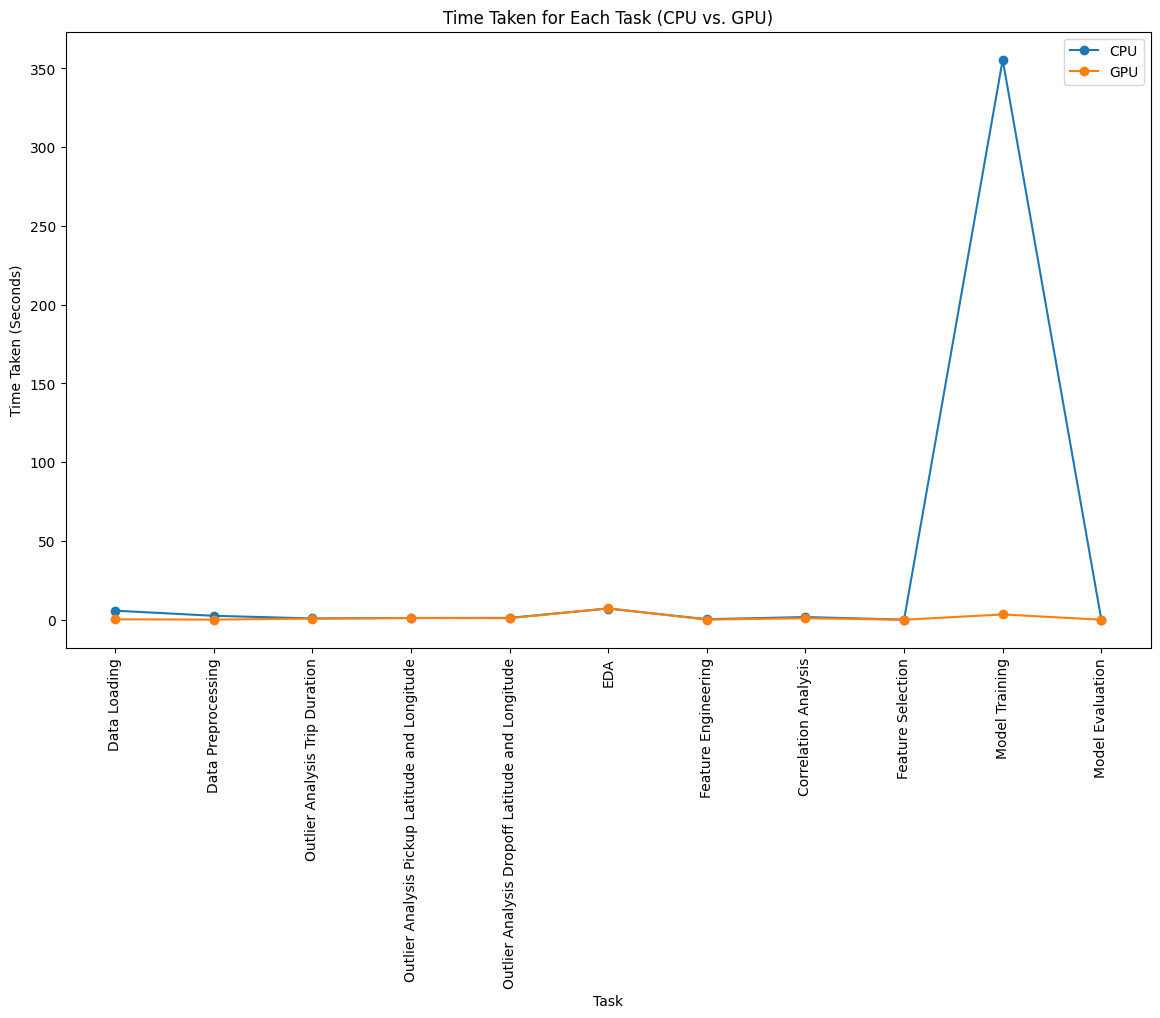

In [131]:
# Plot the time taken for each task for both CPU and GPU implementations
plt.figure(figsize=(14, 8))
# Plot the time taken for each task for both CPU and GPU implementations
plt.plot(cpu_metrics['Task'], cpu_metrics['time_taken'], label='CPU', marker='o')
plt.plot(gpu_metrics['Task'], gpu_metrics['time_taken'], label='GPU', marker='o')
plt.title('Time Taken for Each Task (CPU vs. GPU)')
plt.xlabel('Task')
plt.ylabel('Time Taken (Seconds)')
plt.xticks(rotation=90)
plt.legend()
plt.show()

From the graph above it can be seen that there is no significant difference between the GPU and the CPU in the time taken for each task except fot the data loading, data preprocessing and model training. The was a major difference between the GPU and the CPU in the time taken for the model training where the GPU took significantly less time to train the model

In [132]:
# Display the total time taken for each implementation
print("Total Time Taken for CPU Implementation: ", cpu_metrics['time_taken'].sum())

print("Total Time Taken for GPU Implementation: ", gpu_metrics['time_taken'].sum())

Total Time Taken for CPU Implementation:  376.0263862609863
Total Time Taken for GPU Implementation:  14.694464206695557


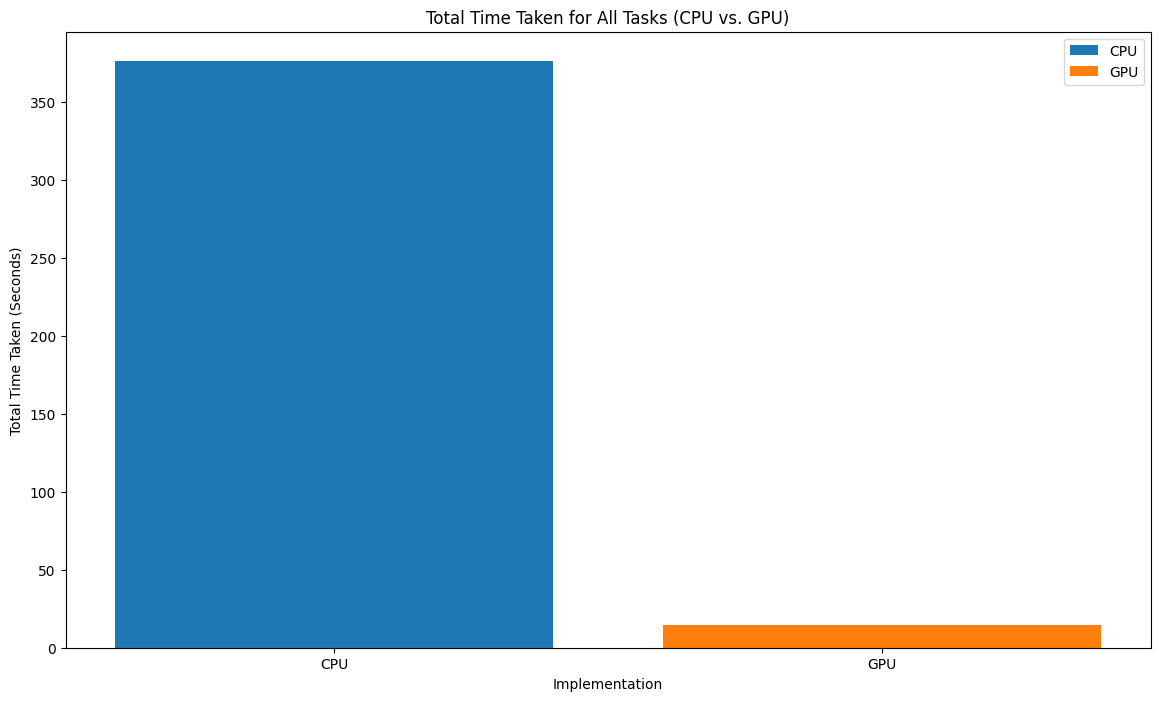

In [133]:
# plot the total time taken for CPU and GPU for all tasks in total

plt.figure(figsize=(14, 8))

# Generate the positions for the bars

# Plot the time taken for each task for both CPU and GPU implementations
plt.bar('CPU', cpu_metrics['time_taken'].sum(), label='CPU')
plt.bar('GPU', gpu_metrics['time_taken'].sum(), label='GPU')

plt.title('Total Time Taken for All Tasks (CPU vs. GPU)')
plt.xlabel('Implementation')

plt.ylabel('Total Time Taken (Seconds)')
plt.legend()

The GPU took in total 14.69 seconds to complete all tasks while the CPU took 376.02 to complete all tasks. This suggests that the GPU spent significanlty less time to complete all tasks but it is worth noting that the 355.52 seconds of the CPU time was spent training the model. 

In [134]:
# Calculate the speedup
speedup = cpu_metrics['time_taken'].sum() / gpu_metrics['time_taken'].sum()

print("Speedup: ", speedup)

Speedup:  25.589662948693924


Based on the speedup the GPU is 25 times faster at completing all the tasks than the cpu

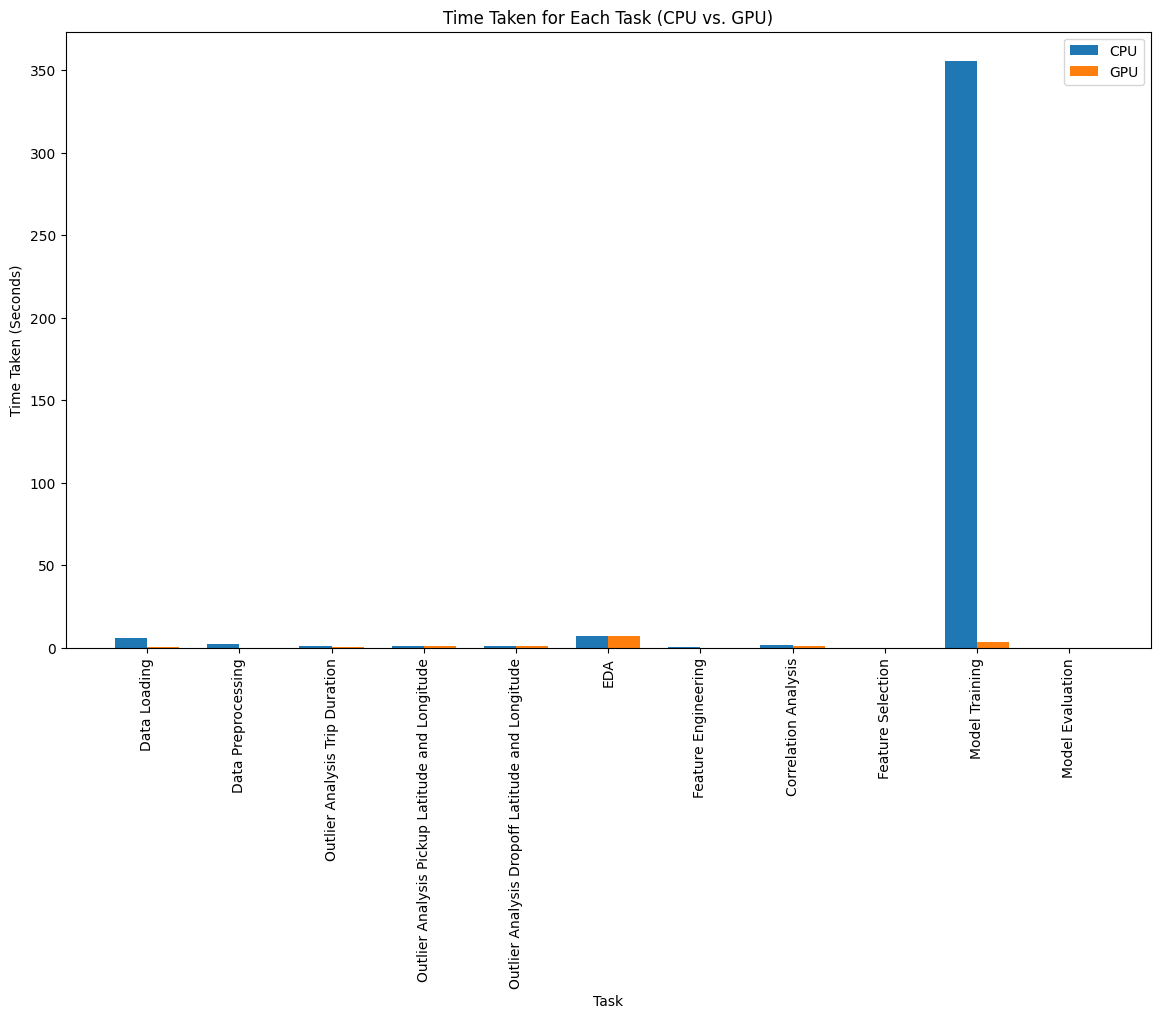

In [135]:
bar_width = 0.35

plt.figure(figsize=(14, 8))

# Generate the positions for the bars
cpu_positions = np.arange(len(cpu_metrics['Task']))
gpu_positions = cpu_positions + bar_width

# Plot the time taken for each task for both CPU and GPU implementations
plt.bar(cpu_positions, cpu_metrics['time_taken'], width=bar_width, label='CPU')
plt.bar(gpu_positions, gpu_metrics['time_taken'], width=bar_width, label='GPU')

plt.title('Time Taken for Each Task (CPU vs. GPU)')
plt.xlabel('Task')
plt.ylabel('Time Taken (Seconds)')
plt.xticks(cpu_positions + bar_width / 2, cpu_metrics['Task'], rotation=90)
plt.legend()

plt.show()

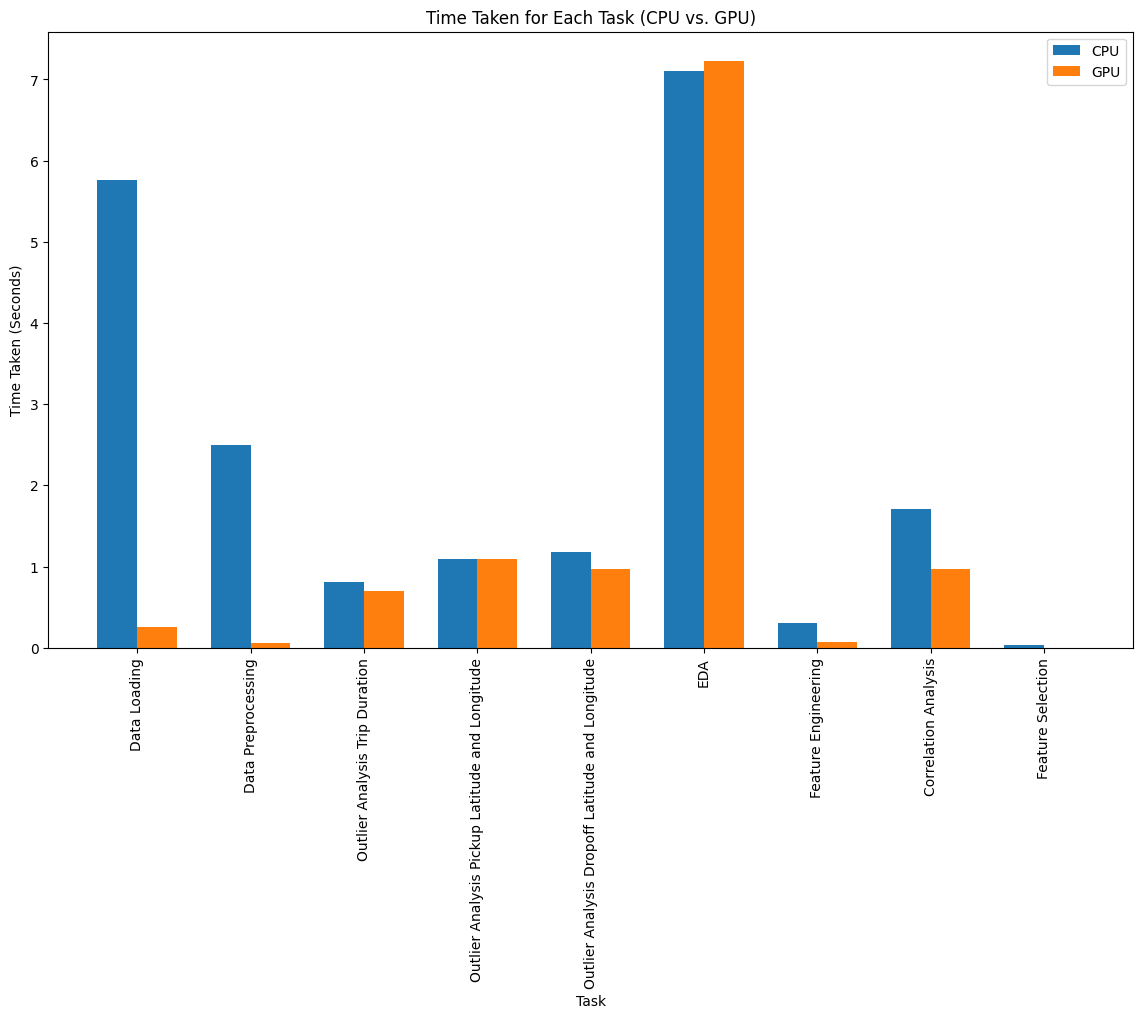

In [137]:
# plot the bar chart without the model training task and model evaluation task
plt.figure(figsize=(14, 8))

# Generate the positions for the bars
cpu_positions = np.arange(len(cpu_metrics['Task']) - 2)
gpu_positions = cpu_positions + bar_width

# Plot the time taken for each task for both CPU and GPU implementations
plt.bar(cpu_positions, cpu_metrics['time_taken'][:-2], width=bar_width, label='CPU')
plt.bar(gpu_positions, gpu_metrics['time_taken'][:-2], width=bar_width, label='GPU')

plt.title('Time Taken for Each Task (CPU vs. GPU)')
plt.xlabel('Task')
plt.ylabel('Time Taken (Seconds)')
plt.xticks(cpu_positions + bar_width / 2, cpu_metrics['Task'][:-2], rotation=90)
plt.legend()

plt.show()

From the Bar graphs above it can be seen that the GPU performed better at all tasks than the CPU especially at data loading, data preprocessing and model training.

In [138]:
!nvidia-smi

Tue Apr 23 00:28:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              32W /  70W |   1097MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [139]:
!lscpu

Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      46 bits physical, 48 bits virtual
CPU(s):                             4
On-line CPU(s) list:                0-3
Thread(s) per core:                 2
Core(s) per socket:                 2
Socket(s):                          1
NUMA node(s):                       1
Vendor ID:                          GenuineIntel
CPU family:                         6
Model:                              85
Model name:                         Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:                           3
CPU MHz:                            2000.184
BogoMIPS:                           4000.36
Hypervisor vendor:                  KVM
Virtualization type:                full
L1d cache:                          64 KiB
L1i cache:                          64 KiB
L2 cache:                           2 MiB
L3 cache:                  

# (b) Discuss the results and provide insights into the performance differences between CPU and GPU implementations.


### Summary of Results
| Task                                            | Time Taken (CPU) | Time Taken (GPU) | Discussion                                                                                                          |
|-------------------------------------------------|------------------|------------------|---------------------------------------------------------------------------------------------------------------------|
| Data Loading                                    | 5.760            | 0.257            | The GPU significantly outperforms the CPU in data loading, completing the task much faster.                         |
| Data Preprocessing                              | 2.494            | 0.063            | Similar to data loading, the GPU excels in data preprocessing, completing the task much faster than the CPU.        |
| Outlier Analysis Trip Duration                  | 0.813            | 0.700            | Both CPU and GPU have similar performance in outlier analysis for trip duration.                                     |
| Outlier Analysis Pickup Latitude and Longitude  | 1.096            | 1.089            | The CPU and GPU have similar performance in outlier analysis for pickup latitude and longitude.                     |
| Outlier Analysis Dropoff Latitude and Longitude | 1.183            | 0.974            | The GPU slightly outperforms the CPU in outlier analysis for dropoff latitude and longitude.                        |
| EDA                                             | 7.107            | 7.226            | The difference in time taken for Exploratory Data Analysis (EDA) between CPU and GPU is minimal.                    |
| Feature Engineering                             | 0.301            | 0.066            | Feature engineering is significantly faster on the GPU compared to the CPU.                                          |
| Correlation Analysis                            | 1.706            | 0.969            | The GPU outperforms the CPU in correlation analysis, significantly reducing the time taken for this task.           |
| Feature Selection                               | 0.037            | 0.001            | Feature selection is substantially faster on the GPU compared to the CPU.                                            |
| Model Training                                  | 355.525          | 3.345            | Model training is drastically faster on the GPU compared to the CPU, with a significant reduction in time taken.     |
| Model Evaluation                                | 0.004            | 0.004            | The time taken for model evaluation is similar for both the CPU and GPU, with negligible differences.                |



The findings suggest that the GPU is significantly faster than the CPU at data loading, data preprocessing and model training. The GPU is 25 times faster than the CPU at completing all the tasks. This means that the GPU is more efficient than the CPU at completing data science tasks. The GPU is also more scalable than the CPU as it can handle larger datasets and more complex models. The GPU is more efficient and scalable than the CPU for data science workflows. 